In [1]:
import os
import h5py

import socket
import struct
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import time

from tqdm import tqdm



import numpy as np
import copy

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

client side


In [3]:
# keep the path same, just create a folder named cifar in your drive
root_path = './cifar'

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [5]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [6]:

trainset1 = torchvision.datasets.CIFAR10(root=root_path, download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar


In [7]:
len(trainset1)

50000

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [9]:
import matplotlib.pyplot as plt


def show_image(img, label):
    print("Label=", trainset1.classes[label], "(" + str(label)  + ")")
    plt.imshow(img.permute(1,2,0))

Label= frog (6)


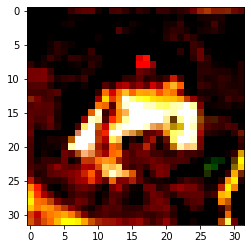

In [10]:
image,label = trainset1[0]
show_image(image, label)

Label= truck (9)


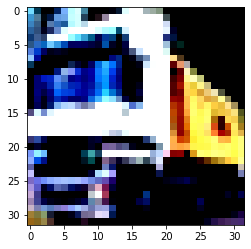

In [11]:
image,label = trainset1[1]
show_image(image, label)

Label= truck (9)


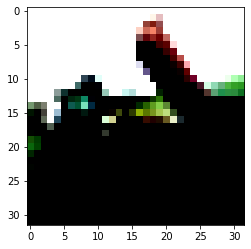

In [12]:
image,label = trainset1[2]
show_image(image, label)

Label= truck (9)


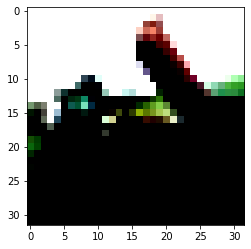

In [13]:
image,label = trainset1[2]
show_image(image, label)

Label= deer (4)


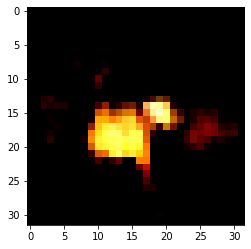

In [14]:
image,label = trainset1[3]
show_image(image, label)

Label= automobile (1)


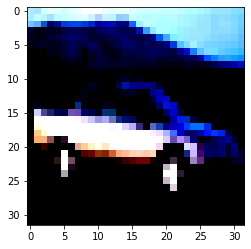

In [15]:
image,label = trainset1[4]
show_image(image, label)

Label= automobile (1)


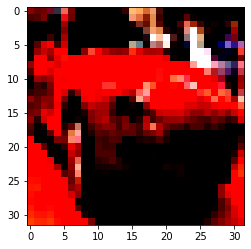

In [16]:
image,label = trainset1[5]
show_image(image, label)

Label= bird (2)


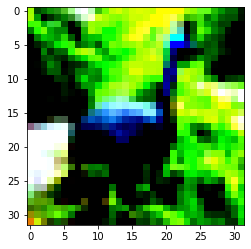

In [17]:
image,label = trainset1[6]
show_image(image, label)

# Define below number of users/clients

In [18]:
users = 5 # clients

In [19]:
trainset1_len = 50000

In [20]:
idxs = np.random.permutation(trainset1_len)
idxs

array([46674, 21513,  7802, ..., 18178, 19762, 15681])

In [21]:
train_indices = idxs
train_indices

array([46674, 21513,  7802, ..., 18178, 19762, 15681])

In [22]:
indices_per_client = int (len(train_indices)/users)

print(indices_per_client)

10000


# trainset2 which has non poisoned data

In [23]:
trainset2 = torchvision.datasets.CIFAR10(root=root_path, download=False, transform=transform)

# TestSet 

In [24]:
testset = torchvision.datasets.CIFAR10 (root=root_path, train=False, download=True, transform=transform)

Files already downloaded and verified


# doing label flipping

In [25]:


# for i in range(len(trainset1)):
#     if (trainset2.targets[i] == 6):
#         trainset2.targets[i] = 8
#     if (trainset2.targets[i] == 2):
#         trainset2.targets[i] = 9

In [26]:
len(testset)

10000

In [27]:
idxs = np.random.permutation(10000)
idxs

array([1960, 1126, 7171, ..., 5375, 5875, 4491])

In [28]:
val_indices = idxs
val_indices 

array([1960, 1126, 7171, ..., 5375, 5875, 4491])

In [29]:
#experimenting 

users = 5



batch_size = 100

train_loaders2 = [] 

train_trainset2=[]

train_loaders1 = []

train_trainset1 = []


for i in range(users):
  start= indices_per_client*i
  end= indices_per_client * (i+1)
  
  #print((train_indices[start:end]))


  train_trainset1.append(list(train_indices[start:end]))

  train_trainset2.append(list(train_indices[start:end]))

  #print(len(train_dataset))

  train_sampler = SubsetRandomSampler(train_indices[start : end])
  # train_loaders= DataLoader(dataset, batch_size, sampler= train_sampler) 

  #####*********************************************************************################
  ##### IMPORTANT : HERE BELOW CHANGE IF CONDITION TO SELECT NO OF POISONED CLIETNS ########
  #####*********************************************************************################

  if i < 0 :
    print("poisoned: ", i)
    train_loaders1.append(DataLoader(trainset1, batch_size=batch_size,sampler=train_sampler)) # client training on poisoned data
  else:
    train_loaders1.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler)) # rest training on normal data
    print("non-poisoned: ", i)



  train_loaders2.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler))

  





val_sampler = SubsetRandomSampler(val_indices)



test_loader = DataLoader(testset, batch_size=batch_size, sampler=val_sampler) 
# 



non-poisoned:  0
non-poisoned:  1
non-poisoned:  2
non-poisoned:  3
non-poisoned:  4


In [30]:
print(len(train_trainset1))

5


In [31]:
len(train_loaders1)

5

In [32]:
from torch.autograd import Variable
import torch.nn.init as init

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [33]:
net_glob = resnet20()
net_glob.to(device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [34]:

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_glob.parameters(), lr=lr, momentum=0.9)


In [35]:
local_epochs = 1

In [36]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [37]:
num_users = 5

frac = 1 # this tells the percentage of clients chosen for each global round. 1=100%(all the clinets are chosen),0.5(only half the clients are chosen)

In [38]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [39]:
# def fgsm_attack(model, loss, images, labels, eps) :
    
#     images = images.to(device)
#     labels = labels.to(device)
#     images.requires_grad = True
           
#     outputs = model(images)
    
#     model.zero_grad()
#     cost = criterion(outputs, labels)
#     cost.backward()
    
#     attack_images = images + eps*images.grad.sign()
#     attack_images = torch.clamp(attack_images, 0, 1)
    
#     return attack_images
def test(net, test_loader, criterion, device, epsilon):
    net.eval()  # set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Generate adversarial examples using FGSM
        data.requires_grad = True
        output = net(data)
        loss = criterion(output, target)
        net.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        with torch.no_grad():
            output = net(perturbed_data)

        # Compute loss and accuracy
        test_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total

    print("Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
        test_loss, correct, total, accuracy))

In [40]:
net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []



for iter in range(200):
    w_locals, loss_locals_train, acc_locals_train, loss_locals_test, acc_locals_test = [], [], [], [], []
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace = False)
    

    global_weights = copy.deepcopy(net_glob.state_dict())
   
    # Training/Testing simulation
    for idx in idxs_users: # each client
        
        net_glob.load_state_dict(global_weights)
        # client training local epochs  
        for local_epoch in range(local_epochs):

          for i, data in enumerate(tqdm(train_loaders1[idx], ncols=100, desc='Round'+str(iter+1)+': User'+str(idx)+'_'+str(local_epoch+1))):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.clone().detach().long().to(device)
            #data.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_glob(inputs)
            loss = criterion(outputs, labels)
            #net_glob.zero_grad()
            loss.backward()
            #data_grad = data.grad.data
            #perturbed_data = fgsm_attack(inputs, 0.3, data_grad)
            #output = net_glob(perturbed_data)
            optimizer.step()
          
        w = copy.deepcopy(net_glob.state_dict())
        w_locals.append(copy.deepcopy(w))
      
      
    w_glob = FedAvg(w_locals)
    # update global model --- copy weight to net_glob -- distributed the model to all users
    net_glob.load_state_dict(w_glob)

    # train acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        train_loss = 0.0
        for idx in idxs_users:
          for j, trn in enumerate(train_loaders2[idx]):
            trn_x, trn_label = trn
            trn_x = trn_x.to(device)
            trn_label = trn_label.clone().detach().long().to(device)

            trn_output = net_glob(trn_x)
            loss = criterion(trn_output, trn_label)
            train_loss += loss.item()
            model_label = trn_output.argmax(dim=1)
            corr = trn_label[trn_label == model_label].size(0)
            corr_num += corr
            total_num += trn_label.size(0)
          print("client:{} train_acc: {:.2f}%, train_loss: {:.4f}".format(idx, corr_num / total_num * 100, train_loss / len(train_loaders2)))

    # Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
    epsilon = 0.4  # choose a value for epsilon
    test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)
#     with torch.no_grad():
#         corr_num = 0
#         total_num = 0
#         val_loss = 0.0
#         for j, val in enumerate(test_loader):
#             val_x, val_label = val
#             val_x = val_x.to(device)
#             data = val_x
            
#             data.requires_grad = True
#             #val_x = fgsm_attack(net_glob, loss, val_x, val_label, 0.3).to(device)
#             val_label = val_label.clone().detach().long().to(device)
#             val_output = net_glob(data)
            
#             loss = criterion(val_output, val_label)
#             net_glob.zero_grad()
#             loss.backward()
#             data_grad = data.grad.data
#             perturbed_data = fgsm_attack(data, 0.3, data_grad)
#             output = net_glob(perturbed_data)
#             val_loss += loss.item()
#             model_label = val_output.argmax(dim=1)
#             corr = val_label[val_label == model_label].size(0)
#             corr_num += corr
#             total_num += val_label.size(0)
#             accuracy = corr_num / total_num * 100
#             test_loss = val_loss / len(test_loader)
#         print("test_acc: {:.2f}%, test_loss: {:.4f}".format( accuracy, test_loss))
    
#     # prepare to count predictions for each class
#     correct_pred = {classname: 0 for classname in classes}
#     total_pred = {classname: 0 for classname in classes}

#     # again no gradients needed
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             outputs = net_glob(images)
#             _, predictions = torch.max(outputs, 1)
#             # collect the correct predictions for each class
#             for label, prediction in zip(labels, predictions):
#                 if label == prediction:
#                     correct_pred[classes[label]] += 1
#                 total_pred[classes[label]] += 1


#     # print accuracy for each class
#     for classname, correct_count in correct_pred.items():
#         accuracy = 100 * float(correct_count) / total_pred[classname]
#         print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
#                                                       accuracy))



Round1: User1_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 23.41it/s]


client:3 train_acc: 26.63%, train_loss: 39.5732
client:0 train_acc: 26.28%, train_loss: 79.1626
client:2 train_acc: 26.23%, train_loss: 118.9038
client:4 train_acc: 26.32%, train_loss: 158.4064
client:1 train_acc: 26.53%, train_loss: 197.9316
Test set: Average loss: 2.6455, Accuracy: 523/10000 (5.23%)


Round2: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 20.97it/s]


client:0 train_acc: 33.16%, train_loss: 35.7797
client:4 train_acc: 32.82%, train_loss: 71.6887
client:3 train_acc: 32.93%, train_loss: 107.6156
client:1 train_acc: 32.93%, train_loss: 143.6077
client:2 train_acc: 32.74%, train_loss: 179.8830
Test set: Average loss: 2.7138, Accuracy: 511/10000 (5.11%)


Round3: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 22.04it/s]


client:4 train_acc: 37.22%, train_loss: 33.7337
client:3 train_acc: 37.34%, train_loss: 67.4942
client:0 train_acc: 37.30%, train_loss: 101.1042
client:1 train_acc: 37.26%, train_loss: 134.8652
client:2 train_acc: 37.22%, train_loss: 168.9713
Test set: Average loss: 2.8210, Accuracy: 652/10000 (6.52%)


Round4: User4_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 23.57it/s]


client:1 train_acc: 39.76%, train_loss: 32.4265
client:3 train_acc: 39.83%, train_loss: 64.8939
client:0 train_acc: 39.74%, train_loss: 97.1940
client:2 train_acc: 39.61%, train_loss: 129.9641
client:4 train_acc: 39.67%, train_loss: 162.3538
Test set: Average loss: 2.8754, Accuracy: 718/10000 (7.18%)


Round5: User4_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 24.49it/s]


client:1 train_acc: 41.79%, train_loss: 31.4462
client:2 train_acc: 41.39%, train_loss: 63.2620
client:0 train_acc: 41.67%, train_loss: 94.5590
client:3 train_acc: 41.54%, train_loss: 126.1244
client:4 train_acc: 41.61%, train_loss: 157.5473
Test set: Average loss: 2.9849, Accuracy: 772/10000 (7.72%)


Round6: User1_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 21.31it/s]


client:4 train_acc: 44.00%, train_loss: 30.5128
client:3 train_acc: 43.71%, train_loss: 61.1554
client:0 train_acc: 43.84%, train_loss: 91.5810
client:2 train_acc: 43.71%, train_loss: 122.4503
client:1 train_acc: 43.78%, train_loss: 153.0188
Test set: Average loss: 2.9854, Accuracy: 823/10000 (8.23%)


Round7: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 24.90it/s]


client:1 train_acc: 45.71%, train_loss: 29.7376
client:3 train_acc: 45.19%, train_loss: 59.5521
client:4 train_acc: 45.33%, train_loss: 89.2745
client:0 train_acc: 45.34%, train_loss: 118.8976
client:2 train_acc: 45.27%, train_loss: 148.9647
Test set: Average loss: 3.0091, Accuracy: 841/10000 (8.41%)


Round8: User3_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 24.28it/s]


client:4 train_acc: 46.22%, train_loss: 29.3246
client:0 train_acc: 46.45%, train_loss: 58.5534
client:1 train_acc: 46.27%, train_loss: 87.9285
client:2 train_acc: 46.12%, train_loss: 117.5930
client:3 train_acc: 45.95%, train_loss: 147.0623
Test set: Average loss: 2.9629, Accuracy: 809/10000 (8.09%)


Round9: User2_1: 100%|████████████████████████████████████████████| 100/100 [00:04<00:00, 21.09it/s]


client:1 train_acc: 47.77%, train_loss: 28.6438
client:3 train_acc: 47.35%, train_loss: 57.3481
client:4 train_acc: 47.47%, train_loss: 85.9155
client:0 train_acc: 47.62%, train_loss: 114.3298
client:2 train_acc: 47.60%, train_loss: 143.2508
Test set: Average loss: 3.0719, Accuracy: 810/10000 (8.10%)


Round10: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.28it/s]


client:1 train_acc: 48.54%, train_loss: 28.2726
client:4 train_acc: 48.46%, train_loss: 56.4881
client:0 train_acc: 48.79%, train_loss: 84.5605
client:2 train_acc: 48.64%, train_loss: 113.0584
client:3 train_acc: 48.41%, train_loss: 141.4051
Test set: Average loss: 3.0458, Accuracy: 849/10000 (8.49%)


Round11: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 22.24it/s]


client:0 train_acc: 50.48%, train_loss: 27.4307
client:4 train_acc: 49.98%, train_loss: 55.0745
client:2 train_acc: 49.60%, train_loss: 83.0527
client:3 train_acc: 49.44%, train_loss: 110.8156
client:1 train_acc: 49.44%, train_loss: 138.5462
Test set: Average loss: 3.0716, Accuracy: 839/10000 (8.39%)


Round12: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.36it/s]


client:1 train_acc: 50.17%, train_loss: 27.3618
client:4 train_acc: 50.16%, train_loss: 54.7154
client:2 train_acc: 50.00%, train_loss: 82.3628
client:3 train_acc: 49.85%, train_loss: 109.7949
client:0 train_acc: 50.03%, train_loss: 136.9488
Test set: Average loss: 3.0175, Accuracy: 873/10000 (8.73%)


Round13: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.90it/s]


client:4 train_acc: 51.77%, train_loss: 26.6856
client:1 train_acc: 51.52%, train_loss: 53.3794
client:0 train_acc: 51.79%, train_loss: 79.7845
client:2 train_acc: 51.60%, train_loss: 106.7789
client:3 train_acc: 51.42%, train_loss: 133.4974
Test set: Average loss: 3.2085, Accuracy: 803/10000 (8.03%)


Round14: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.01it/s]


client:1 train_acc: 52.17%, train_loss: 26.3237
client:2 train_acc: 52.13%, train_loss: 52.9077
client:4 train_acc: 52.33%, train_loss: 79.1522
client:3 train_acc: 52.19%, train_loss: 105.4425
client:0 train_acc: 52.38%, train_loss: 131.4455
Test set: Average loss: 3.1464, Accuracy: 824/10000 (8.24%)


Round15: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.86it/s]


client:0 train_acc: 54.00%, train_loss: 25.7208
client:4 train_acc: 53.39%, train_loss: 51.7409
client:2 train_acc: 53.08%, train_loss: 78.0177
client:3 train_acc: 52.79%, train_loss: 104.0563
client:1 train_acc: 52.82%, train_loss: 130.1417
Test set: Average loss: 3.2175, Accuracy: 870/10000 (8.70%)


Round16: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.59it/s]


client:4 train_acc: 53.89%, train_loss: 25.4927
client:1 train_acc: 53.76%, train_loss: 51.0705
client:0 train_acc: 54.16%, train_loss: 76.2979
client:3 train_acc: 53.91%, train_loss: 101.8741
client:2 train_acc: 53.76%, train_loss: 127.7252
Test set: Average loss: 3.3125, Accuracy: 846/10000 (8.46%)


Round17: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.05it/s]


client:0 train_acc: 55.65%, train_loss: 24.8160
client:3 train_acc: 54.97%, train_loss: 49.9610
client:1 train_acc: 54.89%, train_loss: 75.2185
client:4 train_acc: 54.82%, train_loss: 100.3615
client:2 train_acc: 54.73%, train_loss: 125.7786
Test set: Average loss: 3.1941, Accuracy: 823/10000 (8.23%)


Round18: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.76it/s]


client:0 train_acc: 56.14%, train_loss: 24.6179
client:2 train_acc: 55.34%, train_loss: 49.8523
client:1 train_acc: 55.28%, train_loss: 74.8795
client:3 train_acc: 55.12%, train_loss: 99.8197
client:4 train_acc: 55.20%, train_loss: 124.7405
Test set: Average loss: 3.1648, Accuracy: 804/10000 (8.04%)


Round19: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 20.96it/s]


client:2 train_acc: 55.61%, train_loss: 24.7510
client:3 train_acc: 55.54%, train_loss: 49.2464
client:4 train_acc: 55.56%, train_loss: 73.7773
client:1 train_acc: 55.63%, train_loss: 98.3584
client:0 train_acc: 55.84%, train_loss: 122.5260
Test set: Average loss: 3.2268, Accuracy: 822/10000 (8.22%)


Round20: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.94it/s]


client:0 train_acc: 57.33%, train_loss: 23.8419
client:4 train_acc: 56.85%, train_loss: 47.9524
client:1 train_acc: 56.75%, train_loss: 72.2095
client:3 train_acc: 56.57%, train_loss: 96.3922
client:2 train_acc: 56.42%, train_loss: 120.8512
Test set: Average loss: 3.1967, Accuracy: 826/10000 (8.26%)


Round21: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.05it/s]


client:1 train_acc: 56.96%, train_loss: 24.1717
client:2 train_acc: 56.53%, train_loss: 48.5266
client:0 train_acc: 56.83%, train_loss: 72.2723
client:3 train_acc: 56.70%, train_loss: 96.3649
client:4 train_acc: 56.70%, train_loss: 120.4420
Test set: Average loss: 3.1115, Accuracy: 840/10000 (8.40%)


Round22: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.08it/s]


client:2 train_acc: 57.54%, train_loss: 23.7148
client:0 train_acc: 58.32%, train_loss: 46.7117
client:1 train_acc: 58.22%, train_loss: 70.2245
client:3 train_acc: 58.07%, train_loss: 93.6400
client:4 train_acc: 58.04%, train_loss: 117.0493
Test set: Average loss: 3.3143, Accuracy: 868/10000 (8.68%)


Round23: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.04it/s]


client:3 train_acc: 57.83%, train_loss: 23.3699
client:0 train_acc: 58.55%, train_loss: 46.2886
client:1 train_acc: 58.44%, train_loss: 69.7139
client:4 train_acc: 58.39%, train_loss: 93.0154
client:2 train_acc: 58.33%, train_loss: 116.5888
Test set: Average loss: 3.4105, Accuracy: 811/10000 (8.11%)


Round24: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.02it/s]


client:4 train_acc: 59.19%, train_loss: 22.9640
client:2 train_acc: 59.03%, train_loss: 46.1878
client:3 train_acc: 58.74%, train_loss: 69.1953
client:0 train_acc: 59.04%, train_loss: 91.7778
client:1 train_acc: 58.99%, train_loss: 114.8832
Test set: Average loss: 3.4338, Accuracy: 781/10000 (7.81%)


Round25: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.15it/s]


client:0 train_acc: 60.42%, train_loss: 22.1783
client:4 train_acc: 60.20%, train_loss: 44.7114
client:2 train_acc: 59.82%, train_loss: 67.5634
client:3 train_acc: 59.66%, train_loss: 90.1969
client:1 train_acc: 59.64%, train_loss: 112.8201
Test set: Average loss: 3.5438, Accuracy: 830/10000 (8.30%)


Round26: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.16it/s]


client:0 train_acc: 59.71%, train_loss: 22.3268
client:1 train_acc: 59.30%, train_loss: 45.0981
client:3 train_acc: 59.08%, train_loss: 67.8958
client:2 train_acc: 58.97%, train_loss: 90.8903
client:4 train_acc: 58.99%, train_loss: 113.6315
Test set: Average loss: 3.5270, Accuracy: 843/10000 (8.43%)


Round27: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.48it/s]


client:4 train_acc: 60.74%, train_loss: 21.9538
client:1 train_acc: 60.49%, train_loss: 44.0710
client:3 train_acc: 60.40%, train_loss: 66.1616
client:2 train_acc: 60.25%, train_loss: 88.5559
client:0 train_acc: 60.44%, train_loss: 110.1771
Test set: Average loss: 3.4332, Accuracy: 818/10000 (8.18%)


Round28: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.37it/s]


client:2 train_acc: 60.35%, train_loss: 22.1915
client:0 train_acc: 60.69%, train_loss: 43.7107
client:3 train_acc: 60.52%, train_loss: 65.7353
client:1 train_acc: 60.46%, train_loss: 87.7642
client:4 train_acc: 60.47%, train_loss: 109.6722
Test set: Average loss: 3.5251, Accuracy: 858/10000 (8.58%)


Round29: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.13it/s]


client:0 train_acc: 62.14%, train_loss: 21.1253
client:3 train_acc: 61.75%, train_loss: 42.7097
client:1 train_acc: 61.70%, train_loss: 64.2823
client:4 train_acc: 61.60%, train_loss: 85.8197
client:2 train_acc: 61.43%, train_loss: 107.6424
Test set: Average loss: 3.6961, Accuracy: 808/10000 (8.08%)


Round30: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.28it/s]


client:0 train_acc: 61.96%, train_loss: 21.4751
client:4 train_acc: 61.48%, train_loss: 43.3109
client:2 train_acc: 60.94%, train_loss: 65.4867
client:1 train_acc: 60.92%, train_loss: 87.3837
client:3 train_acc: 60.82%, train_loss: 109.3616
Test set: Average loss: 3.9902, Accuracy: 847/10000 (8.47%)


Round31: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.64it/s]


client:4 train_acc: 62.18%, train_loss: 21.2174
client:0 train_acc: 62.64%, train_loss: 42.0484
client:2 train_acc: 62.32%, train_loss: 63.5834
client:3 train_acc: 62.20%, train_loss: 84.8647
client:1 train_acc: 62.15%, train_loss: 106.1546
Test set: Average loss: 3.6322, Accuracy: 827/10000 (8.27%)


Round32: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 22.83it/s]


client:3 train_acc: 62.55%, train_loss: 21.0937
client:4 train_acc: 62.61%, train_loss: 42.0017
client:0 train_acc: 62.92%, train_loss: 62.5316
client:2 train_acc: 62.66%, train_loss: 83.9248
client:1 train_acc: 62.67%, train_loss: 105.0177
Test set: Average loss: 3.4636, Accuracy: 782/10000 (7.82%)


Round33: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.15it/s]


client:4 train_acc: 63.26%, train_loss: 20.6042
client:1 train_acc: 63.29%, train_loss: 41.3712
client:0 train_acc: 63.53%, train_loss: 61.4603
client:2 train_acc: 63.39%, train_loss: 82.3968
client:3 train_acc: 63.29%, train_loss: 103.1502
Test set: Average loss: 3.6682, Accuracy: 840/10000 (8.40%)


Round34: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]


client:3 train_acc: 63.09%, train_loss: 20.6379
client:0 train_acc: 63.72%, train_loss: 40.6814
client:4 train_acc: 63.66%, train_loss: 61.1562
client:1 train_acc: 63.69%, train_loss: 81.8131
client:2 train_acc: 63.57%, train_loss: 102.7352
Test set: Average loss: 3.5172, Accuracy: 776/10000 (7.76%)


Round35: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.86it/s]


client:1 train_acc: 64.09%, train_loss: 20.2661
client:0 train_acc: 64.57%, train_loss: 39.9597
client:3 train_acc: 64.30%, train_loss: 60.2619
client:4 train_acc: 64.19%, train_loss: 80.4468
client:2 train_acc: 64.02%, train_loss: 101.0345
Test set: Average loss: 3.5396, Accuracy: 761/10000 (7.61%)


Round36: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.12it/s]


client:1 train_acc: 64.05%, train_loss: 20.2628
client:3 train_acc: 63.98%, train_loss: 40.5972
client:4 train_acc: 64.03%, train_loss: 60.7629
client:2 train_acc: 63.79%, train_loss: 81.3362
client:0 train_acc: 64.05%, train_loss: 101.0887
Test set: Average loss: 3.5503, Accuracy: 800/10000 (8.00%)


Round37: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.40it/s]


client:1 train_acc: 64.71%, train_loss: 20.0103
client:2 train_acc: 64.36%, train_loss: 40.2442
client:0 train_acc: 64.75%, train_loss: 59.7333
client:3 train_acc: 64.65%, train_loss: 79.7803
client:4 train_acc: 64.66%, train_loss: 99.6701
Test set: Average loss: 3.4948, Accuracy: 783/10000 (7.83%)


Round38: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.40it/s]


client:3 train_acc: 64.57%, train_loss: 19.9489
client:4 train_acc: 64.55%, train_loss: 39.7733
client:2 train_acc: 64.45%, train_loss: 59.9697
client:1 train_acc: 64.56%, train_loss: 79.8810
client:0 train_acc: 64.86%, train_loss: 99.2041
Test set: Average loss: 3.6471, Accuracy: 804/10000 (8.04%)


Round39: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.89it/s]


client:3 train_acc: 64.44%, train_loss: 19.9123
client:2 train_acc: 64.52%, train_loss: 40.0339
client:0 train_acc: 64.96%, train_loss: 59.2910
client:4 train_acc: 64.90%, train_loss: 79.0150
client:1 train_acc: 64.92%, train_loss: 98.9023
Test set: Average loss: 3.6467, Accuracy: 778/10000 (7.78%)


Round40: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.25it/s]


client:0 train_acc: 65.37%, train_loss: 19.4680
client:3 train_acc: 64.97%, train_loss: 39.5022
client:1 train_acc: 65.00%, train_loss: 59.4532
client:4 train_acc: 65.12%, train_loss: 79.2573
client:2 train_acc: 64.94%, train_loss: 99.4813
Test set: Average loss: 3.5096, Accuracy: 810/10000 (8.10%)


Round41: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


client:1 train_acc: 66.08%, train_loss: 19.3381
client:3 train_acc: 65.60%, train_loss: 38.7559
client:2 train_acc: 65.49%, train_loss: 58.3110
client:4 train_acc: 65.59%, train_loss: 77.5343
client:0 train_acc: 65.78%, train_loss: 96.2957
Test set: Average loss: 3.7228, Accuracy: 896/10000 (8.96%)


Round42: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.99it/s]


client:1 train_acc: 66.35%, train_loss: 19.0477
client:2 train_acc: 66.07%, train_loss: 38.2612
client:0 train_acc: 66.39%, train_loss: 56.7062
client:4 train_acc: 66.30%, train_loss: 75.7002
client:3 train_acc: 66.16%, train_loss: 94.7847
Test set: Average loss: 3.8288, Accuracy: 824/10000 (8.24%)


Round43: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.59it/s]


client:2 train_acc: 65.29%, train_loss: 19.5087
client:1 train_acc: 65.84%, train_loss: 38.6287
client:0 train_acc: 66.23%, train_loss: 57.2835
client:4 train_acc: 66.18%, train_loss: 76.3945
client:3 train_acc: 66.08%, train_loss: 95.6464
Test set: Average loss: 3.8690, Accuracy: 778/10000 (7.78%)


Round44: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.42it/s]


client:1 train_acc: 67.14%, train_loss: 18.9108
client:0 train_acc: 67.25%, train_loss: 37.2065
client:2 train_acc: 67.04%, train_loss: 56.2757
client:4 train_acc: 66.86%, train_loss: 75.0916
client:3 train_acc: 66.73%, train_loss: 94.0650
Test set: Average loss: 3.7479, Accuracy: 836/10000 (8.36%)


Round45: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.13it/s]


client:2 train_acc: 66.83%, train_loss: 18.7869
client:3 train_acc: 66.92%, train_loss: 37.4058
client:0 train_acc: 67.37%, train_loss: 55.3699
client:4 train_acc: 67.34%, train_loss: 73.8117
client:1 train_acc: 67.29%, train_loss: 92.3520
Test set: Average loss: 3.7118, Accuracy: 829/10000 (8.29%)


Round46: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.95it/s]


client:3 train_acc: 67.02%, train_loss: 18.5155
client:2 train_acc: 67.13%, train_loss: 37.1879
client:4 train_acc: 67.15%, train_loss: 55.5369
client:1 train_acc: 67.24%, train_loss: 73.9449
client:0 train_acc: 67.48%, train_loss: 91.7372
Test set: Average loss: 3.8470, Accuracy: 841/10000 (8.41%)


Round47: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


client:1 train_acc: 66.92%, train_loss: 18.8107
client:2 train_acc: 66.96%, train_loss: 37.7208
client:4 train_acc: 66.81%, train_loss: 56.5410
client:3 train_acc: 66.75%, train_loss: 75.3479
client:0 train_acc: 66.96%, train_loss: 93.6331
Test set: Average loss: 3.5857, Accuracy: 806/10000 (8.06%)


Round48: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


client:2 train_acc: 67.44%, train_loss: 18.5142
client:1 train_acc: 67.61%, train_loss: 36.7612
client:4 train_acc: 67.76%, train_loss: 54.9117
client:0 train_acc: 68.04%, train_loss: 72.6118
client:3 train_acc: 67.90%, train_loss: 90.9331
Test set: Average loss: 3.6401, Accuracy: 815/10000 (8.15%)


Round49: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.41it/s]


client:0 train_acc: 69.34%, train_loss: 17.3562
client:4 train_acc: 68.78%, train_loss: 35.2820
client:3 train_acc: 68.49%, train_loss: 53.3137
client:1 train_acc: 68.46%, train_loss: 71.2241
client:2 train_acc: 68.34%, train_loss: 89.3799
Test set: Average loss: 3.8274, Accuracy: 816/10000 (8.16%)


Round50: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.87it/s]


client:2 train_acc: 68.40%, train_loss: 17.9681
client:1 train_acc: 68.59%, train_loss: 35.6889
client:4 train_acc: 68.62%, train_loss: 53.3660
client:0 train_acc: 68.85%, train_loss: 70.5488
client:3 train_acc: 68.78%, train_loss: 88.3877
Test set: Average loss: 3.7933, Accuracy: 859/10000 (8.59%)


Round51: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


client:4 train_acc: 68.71%, train_loss: 17.6937
client:0 train_acc: 69.25%, train_loss: 34.8925
client:2 train_acc: 68.97%, train_loss: 52.8887
client:3 train_acc: 68.81%, train_loss: 70.7219
client:1 train_acc: 68.75%, train_loss: 88.5588
Test set: Average loss: 3.6829, Accuracy: 870/10000 (8.70%)


Round52: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


client:1 train_acc: 69.03%, train_loss: 17.5667
client:2 train_acc: 68.99%, train_loss: 35.2599
client:3 train_acc: 68.88%, train_loss: 52.9002
client:4 train_acc: 68.97%, train_loss: 70.3902
client:0 train_acc: 69.23%, train_loss: 87.3978
Test set: Average loss: 3.9475, Accuracy: 834/10000 (8.34%)


Round53: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.78it/s]


client:1 train_acc: 69.06%, train_loss: 17.6318
client:3 train_acc: 68.79%, train_loss: 35.3328
client:2 train_acc: 68.75%, train_loss: 53.1254
client:0 train_acc: 69.01%, train_loss: 70.2577
client:4 train_acc: 69.02%, train_loss: 87.7918
Test set: Average loss: 3.8033, Accuracy: 850/10000 (8.50%)


Round54: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.98it/s]


client:1 train_acc: 69.25%, train_loss: 17.3769
client:2 train_acc: 69.08%, train_loss: 34.9124
client:4 train_acc: 69.22%, train_loss: 52.1349
client:3 train_acc: 69.15%, train_loss: 69.6264
client:0 train_acc: 69.33%, train_loss: 86.4924
Test set: Average loss: 3.8993, Accuracy: 844/10000 (8.44%)


Round55: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.02it/s]


client:4 train_acc: 70.39%, train_loss: 16.8412
client:0 train_acc: 70.78%, train_loss: 33.2372
client:2 train_acc: 70.46%, train_loss: 50.3676
client:1 train_acc: 70.39%, train_loss: 67.2269
client:3 train_acc: 70.28%, train_loss: 84.2461
Test set: Average loss: 3.9195, Accuracy: 836/10000 (8.36%)


Round56: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.17it/s]


client:0 train_acc: 71.15%, train_loss: 16.4810
client:3 train_acc: 70.50%, train_loss: 33.5624
client:1 train_acc: 70.32%, train_loss: 50.5279
client:4 train_acc: 70.27%, train_loss: 67.4187
client:2 train_acc: 70.17%, train_loss: 84.6797
Test set: Average loss: 3.7241, Accuracy: 858/10000 (8.58%)


Round57: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.41it/s]


client:1 train_acc: 69.69%, train_loss: 16.9720
client:2 train_acc: 69.82%, train_loss: 34.1787
client:3 train_acc: 69.82%, train_loss: 51.1931
client:0 train_acc: 70.13%, train_loss: 67.5842
client:4 train_acc: 70.04%, train_loss: 84.5631
Test set: Average loss: 3.9280, Accuracy: 892/10000 (8.92%)


Round58: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.46it/s]


client:4 train_acc: 70.91%, train_loss: 16.5956
client:1 train_acc: 70.50%, train_loss: 33.2883
client:0 train_acc: 70.84%, train_loss: 49.5495
client:3 train_acc: 70.69%, train_loss: 66.3115
client:2 train_acc: 70.62%, train_loss: 83.2910
Test set: Average loss: 3.8781, Accuracy: 892/10000 (8.92%)


Round59: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.39it/s]


client:0 train_acc: 71.13%, train_loss: 16.3475
client:4 train_acc: 70.80%, train_loss: 33.1807
client:1 train_acc: 70.55%, train_loss: 50.0134
client:2 train_acc: 70.51%, train_loss: 66.9511
client:3 train_acc: 70.40%, train_loss: 83.8367
Test set: Average loss: 3.8239, Accuracy: 906/10000 (9.06%)


Round60: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.99it/s]


client:4 train_acc: 71.25%, train_loss: 16.3461
client:3 train_acc: 71.01%, train_loss: 32.8607
client:2 train_acc: 71.01%, train_loss: 49.4541
client:1 train_acc: 71.01%, train_loss: 65.9157
client:0 train_acc: 71.22%, train_loss: 81.8869
Test set: Average loss: 3.7300, Accuracy: 849/10000 (8.49%)


Round61: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.33it/s]


client:2 train_acc: 71.39%, train_loss: 16.4622
client:0 train_acc: 71.99%, train_loss: 32.1410
client:3 train_acc: 71.69%, train_loss: 48.4607
client:4 train_acc: 71.59%, train_loss: 64.7025
client:1 train_acc: 71.54%, train_loss: 80.9448
Test set: Average loss: 3.8961, Accuracy: 892/10000 (8.92%)


Round62: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.11it/s]


client:2 train_acc: 71.50%, train_loss: 16.3160
client:3 train_acc: 71.41%, train_loss: 32.5876
client:4 train_acc: 71.48%, train_loss: 48.6927
client:0 train_acc: 71.80%, train_loss: 64.3103
client:1 train_acc: 71.77%, train_loss: 80.4390
Test set: Average loss: 4.0701, Accuracy: 922/10000 (9.22%)


Round63: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.06it/s]


client:2 train_acc: 71.80%, train_loss: 16.2493
client:4 train_acc: 71.98%, train_loss: 32.1563
client:1 train_acc: 71.81%, train_loss: 48.1746
client:0 train_acc: 72.00%, train_loss: 63.7548
client:3 train_acc: 71.92%, train_loss: 79.8627
Test set: Average loss: 4.0949, Accuracy: 884/10000 (8.84%)


Round64: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.93it/s]


client:2 train_acc: 71.75%, train_loss: 16.2572
client:1 train_acc: 71.60%, train_loss: 32.3150
client:4 train_acc: 71.57%, train_loss: 48.4007
client:0 train_acc: 71.77%, train_loss: 64.0287
client:3 train_acc: 71.70%, train_loss: 80.1872
Test set: Average loss: 4.2446, Accuracy: 919/10000 (9.19%)


Round65: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.25it/s]


client:4 train_acc: 72.07%, train_loss: 15.7999
client:0 train_acc: 72.59%, train_loss: 31.2407
client:3 train_acc: 72.40%, train_loss: 47.2131
client:2 train_acc: 72.37%, train_loss: 63.2829
client:1 train_acc: 72.32%, train_loss: 79.1872
Test set: Average loss: 3.7864, Accuracy: 918/10000 (9.18%)


Round66: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.71it/s]


client:3 train_acc: 72.10%, train_loss: 15.7272
client:2 train_acc: 72.17%, train_loss: 31.6115
client:4 train_acc: 72.30%, train_loss: 47.1594
client:1 train_acc: 72.31%, train_loss: 62.7995
client:0 train_acc: 72.52%, train_loss: 77.9956
Test set: Average loss: 3.9312, Accuracy: 908/10000 (9.08%)


Round67: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.70it/s]


client:4 train_acc: 72.90%, train_loss: 15.4998
client:2 train_acc: 72.80%, train_loss: 31.3427
client:0 train_acc: 72.86%, train_loss: 46.5652
client:1 train_acc: 72.78%, train_loss: 62.2016
client:3 train_acc: 72.65%, train_loss: 77.9576
Test set: Average loss: 3.9745, Accuracy: 928/10000 (9.28%)


Round68: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.19it/s]


client:2 train_acc: 72.59%, train_loss: 15.8075
client:4 train_acc: 72.57%, train_loss: 31.3021
client:0 train_acc: 72.88%, train_loss: 46.3979
client:1 train_acc: 72.74%, train_loss: 61.9679
client:3 train_acc: 72.72%, train_loss: 77.5819
Test set: Average loss: 3.8794, Accuracy: 907/10000 (9.07%)


Round69: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.04it/s]


client:1 train_acc: 72.98%, train_loss: 15.3700
client:2 train_acc: 72.68%, train_loss: 30.9271
client:4 train_acc: 72.72%, train_loss: 46.2761
client:3 train_acc: 72.71%, train_loss: 61.7291
client:0 train_acc: 72.91%, train_loss: 76.7136
Test set: Average loss: 3.8974, Accuracy: 907/10000 (9.07%)


Round70: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]


client:4 train_acc: 73.47%, train_loss: 15.1375
client:2 train_acc: 73.34%, train_loss: 30.5281
client:1 train_acc: 73.30%, train_loss: 45.7372
client:3 train_acc: 73.26%, train_loss: 61.0528
client:0 train_acc: 73.49%, train_loss: 75.7731
Test set: Average loss: 3.8197, Accuracy: 945/10000 (9.45%)


Round71: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.12it/s]


client:3 train_acc: 73.08%, train_loss: 15.2501
client:0 train_acc: 73.67%, train_loss: 29.9189
client:2 train_acc: 73.53%, train_loss: 45.2367
client:1 train_acc: 73.41%, train_loss: 60.4239
client:4 train_acc: 73.39%, train_loss: 75.5663
Test set: Average loss: 4.1435, Accuracy: 973/10000 (9.73%)


Round72: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


client:1 train_acc: 73.76%, train_loss: 14.8629
client:0 train_acc: 74.03%, train_loss: 29.4294
client:4 train_acc: 74.00%, train_loss: 44.2983
client:3 train_acc: 74.02%, train_loss: 59.3189
client:2 train_acc: 73.91%, train_loss: 74.4511
Test set: Average loss: 3.9670, Accuracy: 891/10000 (8.91%)


Round73: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.07it/s]


client:3 train_acc: 73.08%, train_loss: 15.2771
client:1 train_acc: 73.11%, train_loss: 30.4060
client:2 train_acc: 73.22%, train_loss: 45.7942
client:4 train_acc: 73.20%, train_loss: 60.9968
client:0 train_acc: 73.43%, train_loss: 75.6960
Test set: Average loss: 4.3541, Accuracy: 848/10000 (8.48%)


Round74: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.55it/s]


client:4 train_acc: 73.75%, train_loss: 14.7954
client:0 train_acc: 74.19%, train_loss: 29.2075
client:1 train_acc: 74.09%, train_loss: 44.0623
client:2 train_acc: 74.03%, train_loss: 59.0473
client:3 train_acc: 74.03%, train_loss: 73.9038
Test set: Average loss: 4.0505, Accuracy: 921/10000 (9.21%)


Round75: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.12it/s]


client:1 train_acc: 73.78%, train_loss: 14.6569
client:3 train_acc: 74.15%, train_loss: 29.4039
client:2 train_acc: 73.97%, train_loss: 44.3336
client:0 train_acc: 74.18%, train_loss: 58.5819
client:4 train_acc: 74.12%, train_loss: 73.2712
Test set: Average loss: 4.2740, Accuracy: 874/10000 (8.74%)


Round76: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 22.42it/s]


client:2 train_acc: 74.66%, train_loss: 14.6284
client:3 train_acc: 74.70%, train_loss: 29.1720
client:0 train_acc: 74.88%, train_loss: 43.1677
client:4 train_acc: 74.81%, train_loss: 57.5755
client:1 train_acc: 74.74%, train_loss: 72.0315
Test set: Average loss: 4.0408, Accuracy: 977/10000 (9.77%)


Round77: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.00it/s]


client:3 train_acc: 74.97%, train_loss: 14.4168
client:0 train_acc: 75.38%, train_loss: 28.3243
client:4 train_acc: 75.18%, train_loss: 42.6549
client:2 train_acc: 75.01%, train_loss: 57.2086
client:1 train_acc: 74.91%, train_loss: 71.5690
Test set: Average loss: 4.2270, Accuracy: 896/10000 (8.96%)


Round78: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.53it/s]


client:4 train_acc: 73.87%, train_loss: 14.8691
client:0 train_acc: 74.28%, train_loss: 29.2543
client:3 train_acc: 74.11%, train_loss: 44.1367
client:2 train_acc: 74.11%, train_loss: 59.0716
client:1 train_acc: 74.03%, train_loss: 73.8949
Test set: Average loss: 4.0791, Accuracy: 978/10000 (9.78%)


Round79: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.03it/s]


client:3 train_acc: 74.98%, train_loss: 14.1826
client:1 train_acc: 75.05%, train_loss: 28.2955
client:4 train_acc: 75.09%, train_loss: 42.3299
client:0 train_acc: 75.30%, train_loss: 56.0511
client:2 train_acc: 75.24%, train_loss: 70.3748
Test set: Average loss: 4.1530, Accuracy: 944/10000 (9.44%)


Round80: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.04it/s]


client:3 train_acc: 75.35%, train_loss: 14.2250
client:0 train_acc: 75.61%, train_loss: 27.9528
client:1 train_acc: 75.31%, train_loss: 42.1421
client:4 train_acc: 75.28%, train_loss: 56.2684
client:2 train_acc: 75.19%, train_loss: 70.7116
Test set: Average loss: 4.3762, Accuracy: 954/10000 (9.54%)


Round81: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


client:0 train_acc: 75.80%, train_loss: 14.0455
client:1 train_acc: 75.06%, train_loss: 28.4893
client:2 train_acc: 75.07%, train_loss: 43.2002
client:3 train_acc: 74.90%, train_loss: 57.7114
client:4 train_acc: 74.88%, train_loss: 72.1185
Test set: Average loss: 3.7952, Accuracy: 978/10000 (9.78%)


Round82: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 22.10it/s]


client:0 train_acc: 76.39%, train_loss: 13.4596
client:4 train_acc: 75.98%, train_loss: 27.3008
client:2 train_acc: 75.92%, train_loss: 41.3391
client:1 train_acc: 75.79%, train_loss: 55.1944
client:3 train_acc: 75.80%, train_loss: 69.0422
Test set: Average loss: 4.0794, Accuracy: 967/10000 (9.67%)


Round83: User3_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.91it/s]


client:1 train_acc: 75.85%, train_loss: 13.8507
client:2 train_acc: 75.74%, train_loss: 27.8980
client:4 train_acc: 75.57%, train_loss: 41.8215
client:0 train_acc: 75.72%, train_loss: 55.3993
client:3 train_acc: 75.77%, train_loss: 69.3075
Test set: Average loss: 3.9730, Accuracy: 963/10000 (9.63%)


Round84: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.35it/s]


client:0 train_acc: 76.29%, train_loss: 13.5598
client:1 train_acc: 76.03%, train_loss: 27.4086
client:3 train_acc: 76.01%, train_loss: 41.3864
client:4 train_acc: 75.89%, train_loss: 55.1791
client:2 train_acc: 75.88%, train_loss: 69.3454
Test set: Average loss: 4.0824, Accuracy: 914/10000 (9.14%)


Round85: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.50it/s]


client:1 train_acc: 75.82%, train_loss: 13.7383
client:2 train_acc: 75.86%, train_loss: 27.7601
client:3 train_acc: 76.01%, train_loss: 41.5367
client:4 train_acc: 75.97%, train_loss: 55.2274
client:0 train_acc: 76.10%, train_loss: 68.6218
Test set: Average loss: 4.0192, Accuracy: 962/10000 (9.62%)


Round86: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.82it/s]


client:3 train_acc: 76.42%, train_loss: 13.5213
client:0 train_acc: 76.75%, train_loss: 26.6471
client:2 train_acc: 76.61%, train_loss: 40.3635
client:1 train_acc: 76.53%, train_loss: 53.7638
client:4 train_acc: 76.55%, train_loss: 67.1268
Test set: Average loss: 4.1733, Accuracy: 920/10000 (9.20%)


Round87: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.93it/s]


client:2 train_acc: 76.03%, train_loss: 13.6977
client:3 train_acc: 76.35%, train_loss: 27.3104
client:4 train_acc: 76.37%, train_loss: 40.8398
client:1 train_acc: 76.33%, train_loss: 54.4387
client:0 train_acc: 76.37%, train_loss: 67.6943
Test set: Average loss: 4.3518, Accuracy: 930/10000 (9.30%)


Round88: User0_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.55it/s]


client:2 train_acc: 77.16%, train_loss: 13.4902
client:1 train_acc: 77.04%, train_loss: 26.7628
client:3 train_acc: 77.06%, train_loss: 40.0984
client:4 train_acc: 76.92%, train_loss: 53.4355
client:0 train_acc: 76.95%, train_loss: 66.4819
Test set: Average loss: 4.2542, Accuracy: 919/10000 (9.19%)


Round89: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 24.52it/s]


client:4 train_acc: 77.06%, train_loss: 13.2075
client:2 train_acc: 76.83%, train_loss: 26.6533
client:0 train_acc: 77.00%, train_loss: 39.4931
client:3 train_acc: 77.01%, train_loss: 52.7398
client:1 train_acc: 76.95%, train_loss: 65.9831
Test set: Average loss: 4.4065, Accuracy: 918/10000 (9.18%)


Round90: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.00it/s]


client:4 train_acc: 76.88%, train_loss: 13.0784
client:1 train_acc: 76.90%, train_loss: 26.1639
client:0 train_acc: 77.31%, train_loss: 38.9524
client:3 train_acc: 77.31%, train_loss: 52.1229
client:2 train_acc: 77.26%, train_loss: 65.5473
Test set: Average loss: 4.0128, Accuracy: 992/10000 (9.92%)


Round91: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.78it/s]


client:0 train_acc: 77.60%, train_loss: 12.7382
client:4 train_acc: 77.24%, train_loss: 25.9151
client:3 train_acc: 77.21%, train_loss: 39.1394
client:1 train_acc: 77.13%, train_loss: 52.3167
client:2 train_acc: 77.16%, train_loss: 65.6262
Test set: Average loss: 4.2544, Accuracy: 979/10000 (9.79%)


Round92: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.09it/s]


client:4 train_acc: 77.97%, train_loss: 12.6850
client:0 train_acc: 78.20%, train_loss: 25.1341
client:3 train_acc: 78.08%, train_loss: 37.9898
client:1 train_acc: 78.01%, train_loss: 50.7494
client:2 train_acc: 77.88%, train_loss: 63.8759
Test set: Average loss: 4.2285, Accuracy: 951/10000 (9.51%)


Round93: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 28.53it/s]


client:1 train_acc: 77.48%, train_loss: 12.8744
client:2 train_acc: 77.44%, train_loss: 25.8729
client:0 train_acc: 77.50%, train_loss: 38.4697
client:3 train_acc: 77.52%, train_loss: 51.3177
client:4 train_acc: 77.42%, train_loss: 64.1578
Test set: Average loss: 4.1304, Accuracy: 938/10000 (9.38%)


Round94: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.71it/s]


client:0 train_acc: 78.96%, train_loss: 12.2204
client:2 train_acc: 78.51%, train_loss: 25.0916
client:4 train_acc: 78.25%, train_loss: 37.7240
client:3 train_acc: 78.14%, train_loss: 50.4222
client:1 train_acc: 78.12%, train_loss: 63.0286
Test set: Average loss: 4.1968, Accuracy: 963/10000 (9.63%)


Round95: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:04<00:00, 23.93it/s]


client:1 train_acc: 77.97%, train_loss: 12.5932
client:3 train_acc: 77.88%, train_loss: 25.2936
client:2 train_acc: 77.74%, train_loss: 38.2415
client:0 train_acc: 77.82%, train_loss: 50.6234
client:4 train_acc: 77.79%, train_loss: 63.1865
Test set: Average loss: 4.2672, Accuracy: 931/10000 (9.31%)


Round96: User4_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 27.91it/s]


client:1 train_acc: 78.28%, train_loss: 12.5210
client:0 train_acc: 78.51%, train_loss: 24.8088
client:2 train_acc: 78.44%, train_loss: 37.5992
client:3 train_acc: 78.35%, train_loss: 50.1847
client:4 train_acc: 78.31%, train_loss: 62.6933
Test set: Average loss: 3.9720, Accuracy: 983/10000 (9.83%)


Round97: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.35it/s]


client:1 train_acc: 78.52%, train_loss: 12.3574
client:3 train_acc: 78.41%, train_loss: 24.7307
client:4 train_acc: 78.40%, train_loss: 37.0829
client:0 train_acc: 78.59%, train_loss: 49.1728
client:2 train_acc: 78.67%, train_loss: 61.7388
Test set: Average loss: 4.2033, Accuracy: 972/10000 (9.72%)


Round98: User1_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 25.63it/s]


client:3 train_acc: 77.92%, train_loss: 12.5287
client:0 train_acc: 78.35%, train_loss: 24.8529
client:4 train_acc: 78.09%, train_loss: 37.4065
client:2 train_acc: 77.98%, train_loss: 50.2688
client:1 train_acc: 78.03%, train_loss: 62.8190
Test set: Average loss: 4.0809, Accuracy: 971/10000 (9.71%)


Round99: User2_1: 100%|███████████████████████████████████████████| 100/100 [00:03<00:00, 26.66it/s]


client:0 train_acc: 79.35%, train_loss: 11.9437
client:4 train_acc: 79.20%, train_loss: 24.0962
client:3 train_acc: 79.12%, train_loss: 36.3466
client:1 train_acc: 79.11%, train_loss: 48.4485
client:2 train_acc: 79.03%, train_loss: 60.8895
Test set: Average loss: 4.3517, Accuracy: 950/10000 (9.50%)


Round100: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.70it/s]


client:3 train_acc: 78.73%, train_loss: 12.1091
client:0 train_acc: 79.19%, train_loss: 23.8042
client:4 train_acc: 79.11%, train_loss: 35.8940
client:2 train_acc: 79.14%, train_loss: 48.1618
client:1 train_acc: 79.15%, train_loss: 60.2462
Test set: Average loss: 4.2672, Accuracy: 966/10000 (9.66%)


Round101: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


client:3 train_acc: 79.13%, train_loss: 12.0836
client:0 train_acc: 79.29%, train_loss: 23.8286
client:1 train_acc: 79.35%, train_loss: 35.7457
client:4 train_acc: 79.34%, train_loss: 47.6913
client:2 train_acc: 79.30%, train_loss: 59.9835
Test set: Average loss: 4.1277, Accuracy: 946/10000 (9.46%)


Round102: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.42it/s]


client:1 train_acc: 79.51%, train_loss: 11.9218
client:2 train_acc: 79.31%, train_loss: 24.1931
client:4 train_acc: 79.26%, train_loss: 36.2520
client:3 train_acc: 79.20%, train_loss: 48.2956
client:0 train_acc: 79.34%, train_loss: 59.9900
Test set: Average loss: 4.4755, Accuracy: 920/10000 (9.20%)


Round103: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.32it/s]


client:3 train_acc: 79.11%, train_loss: 12.0470
client:4 train_acc: 79.12%, train_loss: 24.0167
client:0 train_acc: 79.35%, train_loss: 35.6960
client:2 train_acc: 79.25%, train_loss: 47.7922
client:1 train_acc: 79.25%, train_loss: 59.7314
Test set: Average loss: 4.0376, Accuracy: 1007/10000 (10.07%)


Round104: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.27it/s]


client:4 train_acc: 79.64%, train_loss: 11.7922
client:1 train_acc: 79.84%, train_loss: 23.5374
client:3 train_acc: 79.75%, train_loss: 35.3508
client:0 train_acc: 79.75%, train_loss: 47.0180
client:2 train_acc: 79.68%, train_loss: 59.0680
Test set: Average loss: 4.3014, Accuracy: 927/10000 (9.27%)


Round105: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.80it/s]


client:1 train_acc: 80.04%, train_loss: 11.5559
client:3 train_acc: 79.96%, train_loss: 23.2122
client:2 train_acc: 79.78%, train_loss: 35.1469
client:4 train_acc: 79.74%, train_loss: 46.8136
client:0 train_acc: 79.85%, train_loss: 58.1904
Test set: Average loss: 4.2464, Accuracy: 942/10000 (9.42%)


Round106: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.24it/s]


client:1 train_acc: 79.76%, train_loss: 11.6344
client:2 train_acc: 79.66%, train_loss: 23.5255
client:3 train_acc: 79.64%, train_loss: 35.2578
client:0 train_acc: 79.78%, train_loss: 46.7480
client:4 train_acc: 79.69%, train_loss: 58.4422
Test set: Average loss: 4.0804, Accuracy: 1010/10000 (10.10%)


Round107: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.11it/s]


client:2 train_acc: 79.99%, train_loss: 11.7711
client:3 train_acc: 79.98%, train_loss: 23.2918
client:4 train_acc: 80.01%, train_loss: 34.7386
client:0 train_acc: 80.09%, train_loss: 46.0087
client:1 train_acc: 80.10%, train_loss: 57.4861
Test set: Average loss: 4.1980, Accuracy: 1017/10000 (10.17%)


Round108: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.34it/s]


client:3 train_acc: 80.19%, train_loss: 11.4258
client:4 train_acc: 80.31%, train_loss: 22.8072
client:0 train_acc: 80.33%, train_loss: 34.0180
client:1 train_acc: 80.40%, train_loss: 45.3050
client:2 train_acc: 80.39%, train_loss: 56.8092
Test set: Average loss: 4.3017, Accuracy: 944/10000 (9.44%)


Round109: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.05it/s]


client:2 train_acc: 80.83%, train_loss: 11.3909
client:3 train_acc: 80.72%, train_loss: 22.6553
client:0 train_acc: 80.83%, train_loss: 33.6422
client:4 train_acc: 80.84%, train_loss: 44.7996
client:1 train_acc: 80.87%, train_loss: 55.9669
Test set: Average loss: 4.1972, Accuracy: 984/10000 (9.84%)


Round110: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.50it/s]


client:2 train_acc: 80.64%, train_loss: 11.4155
client:3 train_acc: 80.60%, train_loss: 22.6597
client:4 train_acc: 80.65%, train_loss: 33.8406
client:0 train_acc: 80.66%, train_loss: 44.9415
client:1 train_acc: 80.65%, train_loss: 56.1233
Test set: Average loss: 4.4666, Accuracy: 1009/10000 (10.09%)


Round111: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.32it/s]


client:0 train_acc: 80.74%, train_loss: 10.9739
client:4 train_acc: 80.86%, train_loss: 21.9896
client:1 train_acc: 80.90%, train_loss: 33.0511
client:2 train_acc: 80.85%, train_loss: 44.3483
client:3 train_acc: 80.85%, train_loss: 55.5234
Test set: Average loss: 4.4820, Accuracy: 943/10000 (9.43%)


Round112: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.44it/s]


client:4 train_acc: 81.54%, train_loss: 10.8554
client:3 train_acc: 81.38%, train_loss: 21.7760
client:1 train_acc: 81.44%, train_loss: 32.5769
client:0 train_acc: 81.48%, train_loss: 43.2929
client:2 train_acc: 81.44%, train_loss: 54.3323
Test set: Average loss: 4.3014, Accuracy: 976/10000 (9.76%)


Round113: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.01it/s]


client:1 train_acc: 80.92%, train_loss: 11.1271
client:3 train_acc: 80.69%, train_loss: 22.2909
client:2 train_acc: 80.65%, train_loss: 33.5216
client:0 train_acc: 80.75%, train_loss: 44.4482
client:4 train_acc: 80.68%, train_loss: 55.5955
Test set: Average loss: 4.0497, Accuracy: 1080/10000 (10.80%)


Round114: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


client:3 train_acc: 81.03%, train_loss: 10.9415
client:2 train_acc: 80.92%, train_loss: 22.1328
client:0 train_acc: 81.12%, train_loss: 32.7405
client:4 train_acc: 81.13%, train_loss: 43.6179
client:1 train_acc: 81.18%, train_loss: 54.4423
Test set: Average loss: 4.3283, Accuracy: 957/10000 (9.57%)


Round115: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


client:1 train_acc: 81.87%, train_loss: 10.6714
client:0 train_acc: 81.73%, train_loss: 21.1972
client:4 train_acc: 81.58%, train_loss: 31.9592
client:2 train_acc: 81.62%, train_loss: 42.7792
client:3 train_acc: 81.63%, train_loss: 53.4939
Test set: Average loss: 4.3106, Accuracy: 990/10000 (9.90%)


Round116: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.81it/s]


client:3 train_acc: 81.44%, train_loss: 10.7198
client:4 train_acc: 81.53%, train_loss: 21.3500
client:0 train_acc: 81.69%, train_loss: 31.8606
client:2 train_acc: 81.66%, train_loss: 42.7005
client:1 train_acc: 81.69%, train_loss: 53.3015
Test set: Average loss: 4.4695, Accuracy: 955/10000 (9.55%)


Round117: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.12it/s]


client:2 train_acc: 81.68%, train_loss: 10.8181
client:3 train_acc: 81.75%, train_loss: 21.4011
client:1 train_acc: 81.83%, train_loss: 31.9234
client:0 train_acc: 81.86%, train_loss: 42.3284
client:4 train_acc: 81.90%, train_loss: 52.8467
Test set: Average loss: 4.3519, Accuracy: 1021/10000 (10.21%)


Round118: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.56it/s]


client:3 train_acc: 82.01%, train_loss: 10.4156
client:4 train_acc: 82.27%, train_loss: 20.6928
client:2 train_acc: 82.15%, train_loss: 31.2922
client:0 train_acc: 82.28%, train_loss: 41.4066
client:1 train_acc: 82.33%, train_loss: 51.6857
Test set: Average loss: 4.4911, Accuracy: 1020/10000 (10.20%)


Round119: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.65it/s]


client:2 train_acc: 82.23%, train_loss: 10.6687
client:4 train_acc: 82.08%, train_loss: 21.0555
client:0 train_acc: 82.07%, train_loss: 31.4280
client:1 train_acc: 82.15%, train_loss: 41.7657
client:3 train_acc: 82.15%, train_loss: 52.2806
Test set: Average loss: 4.4210, Accuracy: 983/10000 (9.83%)


Round120: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.07it/s]


client:1 train_acc: 82.38%, train_loss: 10.2895
client:3 train_acc: 82.16%, train_loss: 20.7062
client:4 train_acc: 82.15%, train_loss: 31.0885
client:2 train_acc: 82.02%, train_loss: 41.7251
client:0 train_acc: 82.04%, train_loss: 52.0068
Test set: Average loss: 4.3849, Accuracy: 984/10000 (9.84%)


Round121: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.36it/s]


client:0 train_acc: 82.29%, train_loss: 10.1218
client:3 train_acc: 82.28%, train_loss: 20.4371
client:2 train_acc: 82.15%, train_loss: 30.9017
client:4 train_acc: 82.25%, train_loss: 41.0419
client:1 train_acc: 82.35%, train_loss: 51.2894
Test set: Average loss: 4.5667, Accuracy: 1057/10000 (10.57%)


Round122: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.10it/s]


client:0 train_acc: 82.95%, train_loss: 10.0615
client:2 train_acc: 82.62%, train_loss: 20.4033
client:4 train_acc: 82.57%, train_loss: 30.5420
client:1 train_acc: 82.58%, train_loss: 40.6737
client:3 train_acc: 82.60%, train_loss: 50.9005
Test set: Average loss: 4.3296, Accuracy: 1001/10000 (10.01%)


Round123: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.03it/s]


client:1 train_acc: 82.66%, train_loss: 10.0660
client:3 train_acc: 82.51%, train_loss: 20.2101
client:0 train_acc: 82.66%, train_loss: 30.0849
client:2 train_acc: 82.57%, train_loss: 40.4538
client:4 train_acc: 82.63%, train_loss: 50.4707
Test set: Average loss: 4.6292, Accuracy: 1015/10000 (10.15%)


Round124: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


client:2 train_acc: 82.31%, train_loss: 10.3415
client:4 train_acc: 82.45%, train_loss: 20.4301
client:3 train_acc: 82.51%, train_loss: 30.6418
client:0 train_acc: 82.50%, train_loss: 40.6756
client:1 train_acc: 82.57%, train_loss: 50.6916
Test set: Average loss: 4.2498, Accuracy: 997/10000 (9.97%)


Round125: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.87it/s]


client:1 train_acc: 83.62%, train_loss: 9.7616
client:2 train_acc: 83.43%, train_loss: 19.8060
client:0 train_acc: 83.49%, train_loss: 29.4482
client:3 train_acc: 83.35%, train_loss: 39.3469
client:4 train_acc: 83.33%, train_loss: 49.1991
Test set: Average loss: 4.4377, Accuracy: 997/10000 (9.97%)


Round126: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.70it/s]


client:0 train_acc: 82.97%, train_loss: 9.7595
client:4 train_acc: 82.91%, train_loss: 19.6260
client:2 train_acc: 82.76%, train_loss: 29.7872
client:1 train_acc: 82.84%, train_loss: 39.6274
client:3 train_acc: 82.87%, train_loss: 49.5797
Test set: Average loss: 4.6801, Accuracy: 984/10000 (9.84%)


Round127: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.09it/s]


client:0 train_acc: 83.38%, train_loss: 9.5211
client:3 train_acc: 83.41%, train_loss: 19.2073
client:4 train_acc: 83.46%, train_loss: 28.8044
client:2 train_acc: 83.39%, train_loss: 38.6985
client:1 train_acc: 83.39%, train_loss: 48.3556
Test set: Average loss: 4.6565, Accuracy: 1023/10000 (10.23%)


Round128: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.28it/s]


client:2 train_acc: 83.76%, train_loss: 9.7291
client:1 train_acc: 83.95%, train_loss: 19.2893
client:4 train_acc: 83.86%, train_loss: 28.9231
client:3 train_acc: 83.75%, train_loss: 38.6487
client:0 train_acc: 83.74%, train_loss: 48.1026
Test set: Average loss: 4.6972, Accuracy: 1010/10000 (10.10%)


Round129: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.67it/s]


client:0 train_acc: 83.74%, train_loss: 9.4931
client:4 train_acc: 83.48%, train_loss: 19.2935
client:1 train_acc: 83.48%, train_loss: 28.8858
client:3 train_acc: 83.47%, train_loss: 38.5988
client:2 train_acc: 83.45%, train_loss: 48.3870
Test set: Average loss: 4.5107, Accuracy: 1026/10000 (10.26%)


Round130: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.17it/s]


client:4 train_acc: 83.42%, train_loss: 9.5600
client:0 train_acc: 83.69%, train_loss: 18.8918
client:3 train_acc: 83.59%, train_loss: 28.4700
client:2 train_acc: 83.56%, train_loss: 38.1904
client:1 train_acc: 83.68%, train_loss: 47.4996
Test set: Average loss: 4.7197, Accuracy: 979/10000 (9.79%)


Round131: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.75it/s]


client:2 train_acc: 83.82%, train_loss: 9.6146
client:4 train_acc: 83.92%, train_loss: 18.8993
client:0 train_acc: 83.90%, train_loss: 28.1842
client:1 train_acc: 83.89%, train_loss: 37.6001
client:3 train_acc: 83.92%, train_loss: 47.0677
Test set: Average loss: 4.5622, Accuracy: 1083/10000 (10.83%)


Round132: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.08it/s]


client:4 train_acc: 83.87%, train_loss: 9.2645
client:2 train_acc: 84.11%, train_loss: 18.6150
client:3 train_acc: 84.17%, train_loss: 27.8494
client:0 train_acc: 84.23%, train_loss: 36.8787
client:1 train_acc: 84.27%, train_loss: 46.0594
Test set: Average loss: 4.5699, Accuracy: 1010/10000 (10.10%)


Round133: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.19it/s]


client:2 train_acc: 84.39%, train_loss: 9.2680
client:3 train_acc: 84.66%, train_loss: 18.2801
client:1 train_acc: 84.75%, train_loss: 27.2209
client:4 train_acc: 84.69%, train_loss: 36.2303
client:0 train_acc: 84.73%, train_loss: 45.1433
Test set: Average loss: 4.5796, Accuracy: 1053/10000 (10.53%)


Round134: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.16it/s]


client:0 train_acc: 84.18%, train_loss: 9.0837
client:4 train_acc: 84.00%, train_loss: 18.4704
client:2 train_acc: 84.01%, train_loss: 27.8821
client:3 train_acc: 83.97%, train_loss: 37.2268
client:1 train_acc: 84.02%, train_loss: 46.4322
Test set: Average loss: 4.8972, Accuracy: 984/10000 (9.84%)


Round135: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.51it/s]


client:0 train_acc: 84.89%, train_loss: 8.7830
client:3 train_acc: 84.91%, train_loss: 17.7590
client:2 train_acc: 84.79%, train_loss: 26.9130
client:1 train_acc: 84.81%, train_loss: 35.7986
client:4 train_acc: 84.82%, train_loss: 44.6536
Test set: Average loss: 4.4097, Accuracy: 1093/10000 (10.93%)


Round136: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]


client:1 train_acc: 85.38%, train_loss: 8.8129
client:4 train_acc: 85.33%, train_loss: 17.6470
client:3 train_acc: 85.37%, train_loss: 26.3983
client:0 train_acc: 85.30%, train_loss: 35.1087
client:2 train_acc: 85.23%, train_loss: 44.0968
Test set: Average loss: 4.3917, Accuracy: 1108/10000 (11.08%)


Round137: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.38it/s]


client:2 train_acc: 84.99%, train_loss: 8.9710
client:4 train_acc: 84.92%, train_loss: 17.8136
client:3 train_acc: 84.90%, train_loss: 26.7724
client:1 train_acc: 84.96%, train_loss: 35.5353
client:0 train_acc: 84.96%, train_loss: 44.2541
Test set: Average loss: 4.3094, Accuracy: 1107/10000 (11.07%)


Round138: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.62it/s]


client:4 train_acc: 85.10%, train_loss: 8.7497
client:3 train_acc: 85.29%, train_loss: 17.5205
client:2 train_acc: 85.29%, train_loss: 26.4038
client:1 train_acc: 85.32%, train_loss: 35.0416
client:0 train_acc: 85.37%, train_loss: 43.5884
Test set: Average loss: 4.5456, Accuracy: 1065/10000 (10.65%)


Round139: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.45it/s]


client:0 train_acc: 86.17%, train_loss: 8.2405
client:2 train_acc: 85.92%, train_loss: 16.8738
client:1 train_acc: 85.97%, train_loss: 25.3074
client:3 train_acc: 85.99%, train_loss: 33.8305
client:4 train_acc: 85.97%, train_loss: 42.2510
Test set: Average loss: 4.4567, Accuracy: 1112/10000 (11.12%)


Round140: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.10it/s]


client:1 train_acc: 86.45%, train_loss: 8.1710
client:0 train_acc: 86.11%, train_loss: 16.3988
client:4 train_acc: 86.17%, train_loss: 24.6158
client:3 train_acc: 86.22%, train_loss: 32.8883
client:2 train_acc: 86.24%, train_loss: 41.3145
Test set: Average loss: 4.5747, Accuracy: 1081/10000 (10.81%)


Round141: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.81it/s]


client:4 train_acc: 85.26%, train_loss: 8.6218
client:3 train_acc: 85.19%, train_loss: 17.3772
client:0 train_acc: 85.08%, train_loss: 26.0860
client:2 train_acc: 85.05%, train_loss: 34.9833
client:1 train_acc: 85.02%, train_loss: 43.7215
Test set: Average loss: 4.3605, Accuracy: 1080/10000 (10.80%)


Round142: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.10it/s]


client:4 train_acc: 86.35%, train_loss: 8.2365
client:3 train_acc: 86.09%, train_loss: 16.5346
client:0 train_acc: 86.05%, train_loss: 24.7392
client:1 train_acc: 86.13%, train_loss: 32.9361
client:2 train_acc: 86.11%, train_loss: 41.3781
Test set: Average loss: 4.5528, Accuracy: 1076/10000 (10.76%)


Round143: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.56it/s]


client:2 train_acc: 85.46%, train_loss: 8.5023
client:3 train_acc: 85.68%, train_loss: 16.7114
client:4 train_acc: 85.70%, train_loss: 25.0778
client:1 train_acc: 85.88%, train_loss: 33.2838
client:0 train_acc: 85.88%, train_loss: 41.5045
Test set: Average loss: 4.6434, Accuracy: 1057/10000 (10.57%)


Round144: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.59it/s]


client:3 train_acc: 85.85%, train_loss: 8.3850
client:0 train_acc: 85.81%, train_loss: 16.6650
client:2 train_acc: 85.71%, train_loss: 25.2044
client:4 train_acc: 85.68%, train_loss: 33.6144
client:1 train_acc: 85.80%, train_loss: 41.8407
Test set: Average loss: 4.7661, Accuracy: 1101/10000 (11.01%)


Round145: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.63it/s]


client:4 train_acc: 86.24%, train_loss: 8.0760
client:0 train_acc: 86.13%, train_loss: 16.0853
client:3 train_acc: 86.26%, train_loss: 24.1758
client:2 train_acc: 86.27%, train_loss: 32.4440
client:1 train_acc: 86.33%, train_loss: 40.4877
Test set: Average loss: 4.7879, Accuracy: 1090/10000 (10.90%)


Round146: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.29it/s]


client:0 train_acc: 86.85%, train_loss: 7.7159
client:3 train_acc: 87.20%, train_loss: 15.4971
client:4 train_acc: 87.26%, train_loss: 23.1729
client:1 train_acc: 87.30%, train_loss: 30.8603
client:2 train_acc: 87.31%, train_loss: 38.7539
Test set: Average loss: 4.6067, Accuracy: 1127/10000 (11.27%)


Round147: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.08it/s]


client:1 train_acc: 87.01%, train_loss: 7.8731
client:4 train_acc: 87.02%, train_loss: 15.7719
client:2 train_acc: 86.86%, train_loss: 23.8778
client:3 train_acc: 86.84%, train_loss: 31.8981
client:0 train_acc: 86.74%, train_loss: 39.8783
Test set: Average loss: 4.5831, Accuracy: 1079/10000 (10.79%)


Round148: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.52it/s]


client:1 train_acc: 87.28%, train_loss: 7.5726
client:0 train_acc: 87.21%, train_loss: 15.1099
client:4 train_acc: 87.31%, train_loss: 22.7079
client:2 train_acc: 87.35%, train_loss: 30.4198
client:3 train_acc: 87.37%, train_loss: 38.0926
Test set: Average loss: 4.7431, Accuracy: 1108/10000 (11.08%)


Round149: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.63it/s]


client:4 train_acc: 87.43%, train_loss: 7.5491
client:0 train_acc: 87.28%, train_loss: 15.0706
client:2 train_acc: 87.26%, train_loss: 22.8717
client:3 train_acc: 87.38%, train_loss: 30.4737
client:1 train_acc: 87.40%, train_loss: 38.0710
Test set: Average loss: 4.7357, Accuracy: 1114/10000 (11.14%)


Round150: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.11it/s]


client:2 train_acc: 87.68%, train_loss: 7.5622
client:0 train_acc: 87.70%, train_loss: 14.8821
client:3 train_acc: 87.76%, train_loss: 22.3770
client:1 train_acc: 87.79%, train_loss: 29.8258
client:4 train_acc: 87.74%, train_loss: 37.3465
Test set: Average loss: 4.9504, Accuracy: 1057/10000 (10.57%)


Round151: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.91it/s]


client:2 train_acc: 87.62%, train_loss: 7.5659
client:0 train_acc: 87.76%, train_loss: 14.8513
client:3 train_acc: 87.88%, train_loss: 22.2617
client:1 train_acc: 87.90%, train_loss: 29.5963
client:4 train_acc: 87.86%, train_loss: 37.0740
Test set: Average loss: 4.8608, Accuracy: 1064/10000 (10.64%)


Round152: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.04it/s]


client:2 train_acc: 87.42%, train_loss: 7.5582
client:0 train_acc: 87.63%, train_loss: 14.7230
client:4 train_acc: 87.74%, train_loss: 21.9964
client:1 train_acc: 87.78%, train_loss: 29.2735
client:3 train_acc: 87.81%, train_loss: 36.6793
Test set: Average loss: 4.9362, Accuracy: 1107/10000 (11.07%)


Round153: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.65it/s]


client:0 train_acc: 87.80%, train_loss: 7.2795
client:1 train_acc: 87.79%, train_loss: 14.6451
client:3 train_acc: 87.86%, train_loss: 21.9586
client:4 train_acc: 87.88%, train_loss: 29.3625
client:2 train_acc: 87.85%, train_loss: 36.8147
Test set: Average loss: 4.8223, Accuracy: 1071/10000 (10.71%)


Round154: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


client:1 train_acc: 87.69%, train_loss: 7.3839
client:2 train_acc: 87.59%, train_loss: 14.9847
client:4 train_acc: 87.56%, train_loss: 22.4349
client:0 train_acc: 87.49%, train_loss: 29.8069
client:3 train_acc: 87.56%, train_loss: 37.2031
Test set: Average loss: 4.9937, Accuracy: 1064/10000 (10.64%)


Round155: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.30it/s]


client:2 train_acc: 87.24%, train_loss: 7.6170
client:3 train_acc: 87.42%, train_loss: 15.0209
client:1 train_acc: 87.67%, train_loss: 22.2192
client:4 train_acc: 87.60%, train_loss: 29.5987
client:0 train_acc: 87.68%, train_loss: 36.8135
Test set: Average loss: 4.6528, Accuracy: 1099/10000 (10.99%)


Round156: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.79it/s]


client:1 train_acc: 87.96%, train_loss: 7.2285
client:3 train_acc: 87.87%, train_loss: 14.5241
client:2 train_acc: 87.80%, train_loss: 21.9348
client:4 train_acc: 87.88%, train_loss: 29.0727
client:0 train_acc: 87.87%, train_loss: 36.2161
Test set: Average loss: 4.8724, Accuracy: 1098/10000 (10.98%)


Round157: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


client:4 train_acc: 87.89%, train_loss: 7.1699
client:0 train_acc: 87.97%, train_loss: 14.2667
client:3 train_acc: 87.86%, train_loss: 21.5614
client:1 train_acc: 87.94%, train_loss: 28.6568
client:2 train_acc: 87.78%, train_loss: 36.2684
Test set: Average loss: 4.9559, Accuracy: 1061/10000 (10.61%)


Round158: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.86it/s]


client:0 train_acc: 88.26%, train_loss: 6.8904
client:2 train_acc: 88.09%, train_loss: 14.0746
client:4 train_acc: 88.12%, train_loss: 21.0728
client:1 train_acc: 88.22%, train_loss: 27.9299
client:3 train_acc: 88.28%, train_loss: 34.9427
Test set: Average loss: 4.9770, Accuracy: 1071/10000 (10.71%)


Round159: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.46it/s]


client:0 train_acc: 88.81%, train_loss: 6.7222
client:3 train_acc: 88.58%, train_loss: 13.6848
client:4 train_acc: 88.57%, train_loss: 20.6147
client:1 train_acc: 88.65%, train_loss: 27.4430
client:2 train_acc: 88.49%, train_loss: 34.6681
Test set: Average loss: 4.7213, Accuracy: 1108/10000 (11.08%)


Round160: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.80it/s]


client:3 train_acc: 88.91%, train_loss: 6.7781
client:4 train_acc: 88.77%, train_loss: 13.5729
client:2 train_acc: 88.79%, train_loss: 20.4208
client:0 train_acc: 88.79%, train_loss: 27.0444
client:1 train_acc: 88.83%, train_loss: 33.7480
Test set: Average loss: 5.0518, Accuracy: 1106/10000 (11.06%)


Round161: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.00it/s]


client:2 train_acc: 88.66%, train_loss: 6.9091
client:0 train_acc: 88.77%, train_loss: 13.5167
client:4 train_acc: 88.80%, train_loss: 20.1918
client:3 train_acc: 88.84%, train_loss: 26.8852
client:1 train_acc: 88.86%, train_loss: 33.5871
Test set: Average loss: 4.8896, Accuracy: 1183/10000 (11.83%)


Round162: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.04it/s]


client:3 train_acc: 88.76%, train_loss: 6.9120
client:0 train_acc: 88.72%, train_loss: 13.7169
client:4 train_acc: 88.67%, train_loss: 20.6222
client:2 train_acc: 88.65%, train_loss: 27.6763
client:1 train_acc: 88.70%, train_loss: 34.4763
Test set: Average loss: 4.8521, Accuracy: 1098/10000 (10.98%)


Round163: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.60it/s]


client:3 train_acc: 89.41%, train_loss: 6.3192
client:1 train_acc: 89.59%, train_loss: 12.5776
client:4 train_acc: 89.61%, train_loss: 18.8881
client:0 train_acc: 89.60%, train_loss: 25.0651
client:2 train_acc: 89.54%, train_loss: 31.5331
Test set: Average loss: 5.0480, Accuracy: 1112/10000 (11.12%)


Round164: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.93it/s]


client:3 train_acc: 89.91%, train_loss: 6.3258
client:1 train_acc: 89.98%, train_loss: 12.5630
client:0 train_acc: 90.12%, train_loss: 18.5706
client:4 train_acc: 90.13%, train_loss: 24.8168
client:2 train_acc: 90.03%, train_loss: 31.2710
Test set: Average loss: 5.1303, Accuracy: 1098/10000 (10.98%)


Round165: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.62it/s]


client:0 train_acc: 89.60%, train_loss: 6.3288
client:4 train_acc: 89.53%, train_loss: 12.8276
client:3 train_acc: 89.65%, train_loss: 19.1886
client:1 train_acc: 89.73%, train_loss: 25.4894
client:2 train_acc: 89.69%, train_loss: 31.9552
Test set: Average loss: 5.1454, Accuracy: 1060/10000 (10.60%)


Round166: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.76it/s]


client:2 train_acc: 87.65%, train_loss: 7.1682
client:1 train_acc: 87.96%, train_loss: 13.9710
client:4 train_acc: 88.15%, train_loss: 20.7330
client:0 train_acc: 88.13%, train_loss: 27.5525
client:3 train_acc: 88.14%, train_loss: 34.4828
Test set: Average loss: 5.0247, Accuracy: 1123/10000 (11.23%)


Round167: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 28.30it/s]


client:2 train_acc: 89.76%, train_loss: 6.3731
client:1 train_acc: 90.03%, train_loss: 12.5040
client:0 train_acc: 90.20%, train_loss: 18.5018
client:4 train_acc: 90.20%, train_loss: 24.6239
client:3 train_acc: 90.21%, train_loss: 30.7774
Test set: Average loss: 5.1314, Accuracy: 1080/10000 (10.80%)


Round168: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.60it/s]


client:2 train_acc: 90.15%, train_loss: 6.0888
client:4 train_acc: 89.92%, train_loss: 12.2748
client:3 train_acc: 89.84%, train_loss: 18.4706
client:1 train_acc: 89.82%, train_loss: 24.6159
client:0 train_acc: 89.80%, train_loss: 30.6887
Test set: Average loss: 5.1990, Accuracy: 1182/10000 (11.82%)


Round169: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.20it/s]


client:3 train_acc: 89.73%, train_loss: 6.2273
client:0 train_acc: 89.92%, train_loss: 12.2126
client:4 train_acc: 89.97%, train_loss: 18.3581
client:1 train_acc: 89.98%, train_loss: 24.4590
client:2 train_acc: 89.81%, train_loss: 30.9161
Test set: Average loss: 5.1702, Accuracy: 1147/10000 (11.47%)


Round170: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.29it/s]


client:1 train_acc: 89.90%, train_loss: 6.1755
client:4 train_acc: 89.70%, train_loss: 12.3761
client:2 train_acc: 89.75%, train_loss: 18.6367
client:0 train_acc: 89.70%, train_loss: 24.7497
client:3 train_acc: 89.72%, train_loss: 30.9512
Test set: Average loss: 5.4813, Accuracy: 1078/10000 (10.78%)


Round171: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


client:0 train_acc: 91.21%, train_loss: 5.4654
client:2 train_acc: 90.89%, train_loss: 11.4129
client:3 train_acc: 90.82%, train_loss: 17.1737
client:1 train_acc: 90.85%, train_loss: 22.8479
client:4 train_acc: 90.90%, train_loss: 28.5394
Test set: Average loss: 5.1373, Accuracy: 1203/10000 (12.03%)


Round172: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.55it/s]


client:1 train_acc: 90.11%, train_loss: 5.9754
client:0 train_acc: 90.15%, train_loss: 11.8688
client:4 train_acc: 90.10%, train_loss: 17.8404
client:2 train_acc: 90.18%, train_loss: 23.8615
client:3 train_acc: 90.21%, train_loss: 29.7534
Test set: Average loss: 4.8024, Accuracy: 1177/10000 (11.77%)


Round173: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.32it/s]


client:1 train_acc: 90.94%, train_loss: 5.6184
client:0 train_acc: 90.91%, train_loss: 11.2610
client:4 train_acc: 90.77%, train_loss: 17.1110
client:3 train_acc: 90.84%, train_loss: 22.7548
client:2 train_acc: 90.75%, train_loss: 28.6688
Test set: Average loss: 5.2934, Accuracy: 1114/10000 (11.14%)


Round174: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.27it/s]


client:1 train_acc: 91.83%, train_loss: 5.3275
client:2 train_acc: 91.55%, train_loss: 10.8935
client:3 train_acc: 91.46%, train_loss: 16.3531
client:4 train_acc: 91.44%, train_loss: 21.8026
client:0 train_acc: 91.45%, train_loss: 27.1991
Test set: Average loss: 5.1973, Accuracy: 1124/10000 (11.24%)


Round175: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.66it/s]


client:3 train_acc: 91.46%, train_loss: 5.4345
client:1 train_acc: 91.51%, train_loss: 10.8360
client:4 train_acc: 91.39%, train_loss: 16.3159
client:0 train_acc: 91.46%, train_loss: 21.6070
client:2 train_acc: 91.33%, train_loss: 27.1804
Test set: Average loss: 5.3151, Accuracy: 1109/10000 (11.09%)


Round176: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.38it/s]


client:4 train_acc: 91.06%, train_loss: 5.4784
client:2 train_acc: 90.80%, train_loss: 11.0966
client:1 train_acc: 90.97%, train_loss: 16.4701
client:0 train_acc: 91.17%, train_loss: 21.5867
client:3 train_acc: 91.10%, train_loss: 27.1165
Test set: Average loss: 5.6511, Accuracy: 1119/10000 (11.19%)


Round177: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.58it/s]


client:4 train_acc: 91.64%, train_loss: 5.3459
client:3 train_acc: 91.67%, train_loss: 10.7269
client:1 train_acc: 91.71%, train_loss: 15.9922
client:0 train_acc: 91.74%, train_loss: 21.1837
client:2 train_acc: 91.54%, train_loss: 26.8143
Test set: Average loss: 5.2469, Accuracy: 1143/10000 (11.43%)


Round178: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.53it/s]


client:1 train_acc: 91.34%, train_loss: 5.3075
client:3 train_acc: 91.27%, train_loss: 10.6010
client:2 train_acc: 91.31%, train_loss: 15.8969
client:0 train_acc: 91.39%, train_loss: 21.0656
client:4 train_acc: 91.30%, train_loss: 26.5767
Test set: Average loss: 5.4313, Accuracy: 1153/10000 (11.53%)


Round179: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.90it/s]


client:4 train_acc: 92.52%, train_loss: 4.8744
client:1 train_acc: 92.42%, train_loss: 9.7600
client:2 train_acc: 92.00%, train_loss: 14.9941
client:0 train_acc: 92.03%, train_loss: 19.8299
client:3 train_acc: 92.05%, train_loss: 24.7954
Test set: Average loss: 5.4893, Accuracy: 1134/10000 (11.34%)


Round180: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.95it/s]


client:2 train_acc: 92.03%, train_loss: 5.0525
client:3 train_acc: 92.19%, train_loss: 9.9371
client:0 train_acc: 92.31%, train_loss: 14.6994
client:4 train_acc: 92.28%, train_loss: 19.6867
client:1 train_acc: 92.30%, train_loss: 24.5944
Test set: Average loss: 5.3209, Accuracy: 1197/10000 (11.97%)


Round181: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


client:1 train_acc: 92.70%, train_loss: 4.8091
client:4 train_acc: 92.38%, train_loss: 9.7884
client:2 train_acc: 92.31%, train_loss: 14.7760
client:3 train_acc: 92.36%, train_loss: 19.6566
client:0 train_acc: 92.40%, train_loss: 24.4853
Test set: Average loss: 5.4313, Accuracy: 1095/10000 (10.95%)


Round182: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.13it/s]


client:4 train_acc: 92.48%, train_loss: 4.8940
client:0 train_acc: 92.53%, train_loss: 9.6011
client:3 train_acc: 92.58%, train_loss: 14.3629
client:1 train_acc: 92.53%, train_loss: 19.2266
client:2 train_acc: 92.43%, train_loss: 24.2747
Test set: Average loss: 5.1803, Accuracy: 1196/10000 (11.96%)


Round183: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.65it/s]


client:4 train_acc: 92.07%, train_loss: 5.0682
client:0 train_acc: 92.18%, train_loss: 9.8632
client:3 train_acc: 92.15%, train_loss: 14.8187
client:2 train_acc: 92.03%, train_loss: 20.0221
client:1 train_acc: 92.12%, train_loss: 24.8872
Test set: Average loss: 5.0089, Accuracy: 1213/10000 (12.13%)


Round184: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


client:1 train_acc: 92.37%, train_loss: 4.8129
client:2 train_acc: 92.32%, train_loss: 9.6595
client:0 train_acc: 92.46%, train_loss: 14.1874
client:4 train_acc: 92.38%, train_loss: 19.0486
client:3 train_acc: 92.36%, train_loss: 23.8856
Test set: Average loss: 5.3203, Accuracy: 1190/10000 (11.90%)


Round185: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.74it/s]


client:3 train_acc: 92.55%, train_loss: 4.7283
client:0 train_acc: 92.81%, train_loss: 9.2065
client:1 train_acc: 92.87%, train_loss: 13.7428
client:2 train_acc: 92.64%, train_loss: 18.6134
client:4 train_acc: 92.65%, train_loss: 23.2669
Test set: Average loss: 5.3660, Accuracy: 1138/10000 (11.38%)


Round186: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 26.92it/s]


client:0 train_acc: 93.40%, train_loss: 4.3596
client:4 train_acc: 93.23%, train_loss: 8.8434
client:2 train_acc: 92.93%, train_loss: 13.5937
client:1 train_acc: 93.02%, train_loss: 18.0278
client:3 train_acc: 92.96%, train_loss: 22.6165
Test set: Average loss: 5.1329, Accuracy: 1246/10000 (12.46%)


Round187: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.30it/s]


client:3 train_acc: 92.69%, train_loss: 4.4660
client:4 train_acc: 92.89%, train_loss: 8.8888
client:0 train_acc: 92.97%, train_loss: 13.2897
client:2 train_acc: 92.85%, train_loss: 17.9326
client:1 train_acc: 92.86%, train_loss: 22.2833
Test set: Average loss: 5.2365, Accuracy: 1254/10000 (12.54%)


Round188: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.48it/s]


client:3 train_acc: 93.72%, train_loss: 4.1688
client:0 train_acc: 93.93%, train_loss: 8.1936
client:1 train_acc: 93.79%, train_loss: 12.3993
client:2 train_acc: 93.61%, train_loss: 16.8007
client:4 train_acc: 93.53%, train_loss: 21.1477
Test set: Average loss: 5.5727, Accuracy: 1202/10000 (12.02%)


Round189: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.40it/s]


client:0 train_acc: 94.00%, train_loss: 4.0967
client:1 train_acc: 93.80%, train_loss: 8.2451
client:2 train_acc: 93.57%, train_loss: 12.6033
client:4 train_acc: 93.58%, train_loss: 16.8009
client:3 train_acc: 93.63%, train_loss: 20.9537
Test set: Average loss: 5.5971, Accuracy: 1225/10000 (12.25%)


Round190: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 22.31it/s]


client:0 train_acc: 93.40%, train_loss: 4.3163
client:4 train_acc: 93.11%, train_loss: 8.7486
client:3 train_acc: 93.19%, train_loss: 13.0154
client:2 train_acc: 93.17%, train_loss: 17.4004
client:1 train_acc: 93.19%, train_loss: 21.7581
Test set: Average loss: 5.6213, Accuracy: 1231/10000 (12.31%)


Round191: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.33it/s]


client:1 train_acc: 92.53%, train_loss: 4.7569
client:3 train_acc: 92.14%, train_loss: 9.6575
client:2 train_acc: 91.90%, train_loss: 14.7214
client:4 train_acc: 91.97%, train_loss: 19.5709
client:0 train_acc: 92.05%, train_loss: 24.2528
Test set: Average loss: 5.4915, Accuracy: 1161/10000 (11.61%)


Round192: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 24.42it/s]


client:0 train_acc: 94.12%, train_loss: 3.9893
client:2 train_acc: 93.42%, train_loss: 8.4840
client:4 train_acc: 93.51%, train_loss: 12.6086
client:3 train_acc: 93.53%, train_loss: 16.8541
client:1 train_acc: 93.63%, train_loss: 20.8842
Test set: Average loss: 5.5302, Accuracy: 1183/10000 (11.83%)


Round193: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.31it/s]


client:4 train_acc: 93.99%, train_loss: 3.8633
client:0 train_acc: 94.08%, train_loss: 7.7712
client:2 train_acc: 93.92%, train_loss: 11.9088
client:1 train_acc: 94.00%, train_loss: 15.8560
client:3 train_acc: 94.06%, train_loss: 19.7602
Test set: Average loss: 5.6276, Accuracy: 1193/10000 (11.93%)


Round194: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.81it/s]


client:4 train_acc: 94.10%, train_loss: 3.9130
client:2 train_acc: 94.06%, train_loss: 7.9050
client:0 train_acc: 94.00%, train_loss: 11.7057
client:1 train_acc: 93.98%, train_loss: 15.6527
client:3 train_acc: 93.96%, train_loss: 19.6167
Test set: Average loss: 5.5099, Accuracy: 1314/10000 (13.14%)


Round195: User4_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.69it/s]


client:0 train_acc: 94.39%, train_loss: 3.7285
client:3 train_acc: 94.12%, train_loss: 7.6314
client:1 train_acc: 94.19%, train_loss: 11.3751
client:2 train_acc: 94.05%, train_loss: 15.3996
client:4 train_acc: 94.08%, train_loss: 19.2533
Test set: Average loss: 5.5260, Accuracy: 1247/10000 (12.47%)


Round196: User1_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 25.20it/s]


client:4 train_acc: 94.27%, train_loss: 3.8157
client:3 train_acc: 94.40%, train_loss: 7.4872
client:0 train_acc: 94.55%, train_loss: 11.0176
client:2 train_acc: 94.39%, train_loss: 14.9278
client:1 train_acc: 94.46%, train_loss: 18.5574
Test set: Average loss: 5.5669, Accuracy: 1245/10000 (12.45%)


Round197: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:06<00:00, 15.36it/s]


client:4 train_acc: 94.06%, train_loss: 3.8248
client:3 train_acc: 94.03%, train_loss: 7.7238
client:0 train_acc: 93.90%, train_loss: 11.6483
client:1 train_acc: 93.96%, train_loss: 15.5091
client:2 train_acc: 93.94%, train_loss: 19.4998
Test set: Average loss: 5.4570, Accuracy: 1189/10000 (11.89%)


Round198: User0_1: 100%|██████████████████████████████████████████| 100/100 [00:04<00:00, 23.38it/s]


client:4 train_acc: 95.12%, train_loss: 3.3418
client:3 train_acc: 95.19%, train_loss: 6.7320
client:1 train_acc: 95.20%, train_loss: 10.1551
client:2 train_acc: 95.07%, train_loss: 13.7214
client:0 train_acc: 95.04%, train_loss: 17.1595
Test set: Average loss: 5.7162, Accuracy: 1256/10000 (12.56%)


Round199: User2_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.20it/s]


client:3 train_acc: 95.09%, train_loss: 3.5036
client:0 train_acc: 94.99%, train_loss: 7.0520
client:4 train_acc: 94.89%, train_loss: 10.6694
client:1 train_acc: 94.95%, train_loss: 14.1593
client:2 train_acc: 94.85%, train_loss: 17.8571
Test set: Average loss: 5.5630, Accuracy: 1255/10000 (12.55%)


Round200: User3_1: 100%|██████████████████████████████████████████| 100/100 [00:03<00:00, 27.78it/s]


client:4 train_acc: 94.83%, train_loss: 3.4564
client:2 train_acc: 94.78%, train_loss: 7.0324
client:1 train_acc: 95.10%, train_loss: 10.2104
client:0 train_acc: 95.14%, train_loss: 13.5512
client:3 train_acc: 95.16%, train_loss: 16.8971
Test set: Average loss: 5.8492, Accuracy: 1201/10000 (12.01%)


In [42]:
# Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
epsilon = 0.4  # choose a value for epsilon
test(net=net_glob, test_loader=test_loader, criterion=criterion, device=device, epsilon=epsilon)


Test set: Average loss: 5.8492, Accuracy: 1201/10000 (12.01%)


In [43]:
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net_glob(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                      accuracy))

RuntimeError: ignored

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import FeatureCollisionAttack

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(301)
#from __future__ import absolute_import, division, print_function, unicode_literals

#import os, sys
#from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
################################# Backdoor_ATTack ###################3
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_dataset('cifar10')

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 30000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [ ]:
y_temp=[]
for i in range(len(y_raw)):
  for j in range(len(y_raw[i])):
    if y_raw[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw=y_temp

In [ ]:
y_temp=[]
for i in range(len(y_raw_test)):
  for j in range(len(y_raw_test[i])):
    if y_raw_test[i][j]==1:
      y_temp.append(j)
y_temp=np.array(y_temp)
y_raw_test=y_temp

In [ ]:
class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence

In [ ]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [ ]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    print(x_clean.shape,"x_clean shape")
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        print(src_imgs.shape,"src images shape")

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        print(imgs_to_be_poisoned.shape,"imgs to be poisoned shape")
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0
    print(x_poison.shape,"x poison shape")
    return is_poison, x_poison, y_poison

In [ ]:
percent_poison = .1
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
#x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
#x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

c = 9 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays
#c_idx=25
plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
